# Oil Spill Detection with Deep Learning

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installing and Loading Libraries

Importing important libraries:

In [2]:
# Loading and plotting images
import os
import cv2

# More Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from random import *

# Machine Learning
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Dense, Dropout, Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, BatchNormalization, Activation, Add
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import clear_output

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Folders locations

In [6]:
TRAIN_IMAGE_DIR = "/content/drive/MyDrive/Satellite_oil_spill_identification/Data/128/Train/Images/Aug_Img/"
TRAIN_MASK_DIR = "/content/drive/MyDrive/Satellite_oil_spill_identification/Data/128/Train/Labels/Masks/"
TEST_IMAGE_DIR = "/content/drive/MyDrive/Satellite_oil_spill_identification/Data/128/Test/Images/Aug_Img/"
TEST_MASK_DIR = "/content/drive/MyDrive/Satellite_oil_spill_identification/Data/128/Test/Labels/Masks/"

train_d = os.listdir(TRAIN_IMAGE_DIR) 

train_d[:10]

['1031024.png',
 '1032015.png',
 '1032047.png',
 '1033014.png',
 '1033022.png',
 '1034014.png',
 '1034015.png',
 '1035019.png',
 '1035015.png',
 '1035035.png']

In [7]:
print(f"There are {len(train_d)} images in the train folder.")

There are 11349 images in the train folder.


# Loading Images and Masks

In [ ]:
x = [np.array(cv2.imread(TRAIN_IMAGE_DIR + p))[:,:,0] for p in train_d]
x = np.array(x)/255

y = [np.array(cv2.imread(TRAIN_MASK_DIR + p, cv2.IMREAD_GRAYSCALE), dtype=np.uint8) for p in train_d]
y = np.array(y)/255

print(x.shape,y.shape)

# Adding Channel Dimension to Images

In [ ]:
x = np.expand_dims(x, axis = 3) #EXPAND DIM OF X AND INSERT NEW AXIS @ 3 
y = np.expand_dims(y, axis = 3)

print(x.shape, y.shape)

(11375, 128, 128, 1) (11375, 128, 128, 1)


# Train/Test Split

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2, random_state = 666)

print(x_train.shape, x_valid.shape)

(9100, 128, 128, 1) (2275, 128, 128, 1)


# Creating Model

Now create the Unet model:

In [ ]:
32*32

In [ ]:
def unet(pretrained_weights = None, input_size = (128,128,3)):

    inputs = Input(input_size)
    
    # 128
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # 128 -> 64
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # 64 -> 32
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # 32 -> 16
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Center: 16 -> 8
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    # 8 -> 16
    up6 = Conv2DTranspose(256, (2,2),strides=(2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop5)
    up6 = BatchNormalization()(up6)
    merge6 = concatenate([drop4,up6],axis=3)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    # 16 -> 32
    up7 = Conv2DTranspose(128,(2,2),strides=(2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    up7 = BatchNormalization()(up7)
    merge7 = concatenate([conv3,up7],axis=3)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    # 32 -> 64
    up8 = Conv2DTranspose(64,(2,2),strides=(2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    up8 = BatchNormalization()(up8)
    merge8 = concatenate([conv2,up8],axis=3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    # 64 -> 128
    up9 = Conv2DTranspose(32,(2,2),strides=(2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    up9 = BatchNormalization()(up9)
    merge9 = concatenate([conv1,up9],axis=3)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

# Training the model

Compiling the model:

In [ ]:
model = unet(input_size = (128,128,1))
model.compile(optimizer = "adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 128, 128, 32  320         ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_96 (BatchN  (None, 128, 128, 32  128        ['conv2d_76[0][0]']              
 ormalization)                  )                                                           

Drawing the model structure:

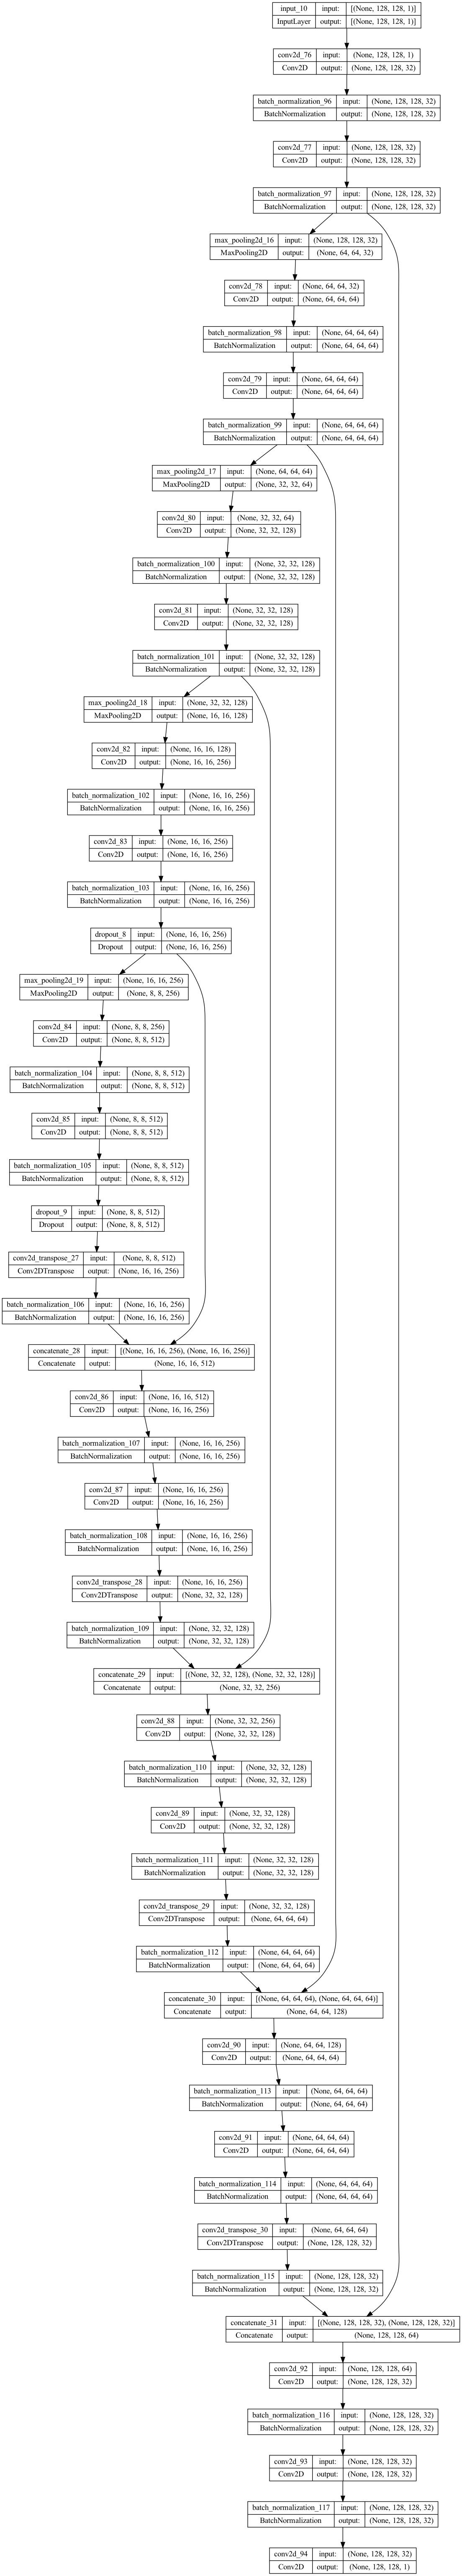

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

## Finally Training the model

Other callbacks:

In [ ]:
monitor = "val_accuracy"
file_model = "./model/keras_unet_gray_32.model"
early_stopping = EarlyStopping(monitor = monitor, patience = 5, verbose = 1)
model_checkpoint = ModelCheckpoint(file_model, monitor = monitor, save_best_only = True, verbose = 1)

callbacks = [early_stopping, model_checkpoint]

In [ ]:
epochs = 30
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data = [x_valid, y_valid], 
                    epochs = epochs,
                    batch_size = batch_size,
                    callbacks = callbacks)

Epoch 1/30


2022-10-11 21:38:53.378653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


285/285 [==============================] - ETA: 0s - loss: 0.3015 - accuracy: 0.9596

2022-10-11 21:41:46.542973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.54974, saving model to ./model/keras_unet_gray_32.model


INFO:tensorflow:Assets written to: ./model/keras_unet_gray_32.model/assets


INFO:tensorflow:Assets written to: ./model/keras_unet_gray_32.model/assets


285/285 [==============================] - 196s 679ms/step - loss: 0.3015 - accuracy: 0.9596 - val_loss: 1.7958 - val_accuracy: 0.5497
Epoch 2/30
285/285 [==============================] - ETA: 0s - loss: 0.0816 - accuracy: 0.9814
Epoch 2: val_accuracy improved from 0.54974 to 0.98189, saving model to ./model/keras_unet_gray_32.model


INFO:tensorflow:Assets written to: ./model/keras_unet_gray_32.model/assets


INFO:tensorflow:Assets written to: ./model/keras_unet_gray_32.model/assets


285/285 [==============================] - 190s 665ms/step - loss: 0.0816 - accuracy: 0.9814 - val_loss: 0.0739 - val_accuracy: 0.9819
Epoch 3/30
285/285 [==============================] - ETA: 0s - loss: 0.0699 - accuracy: 0.9818
Epoch 3: val_accuracy improved from 0.98189 to 0.98204, saving model to ./model/keras_unet_gray_32.model


INFO:tensorflow:Assets written to: ./model/keras_unet_gray_32.model/assets


INFO:tensorflow:Assets written to: ./model/keras_unet_gray_32.model/assets


285/285 [==============================] - 190s 665ms/step - loss: 0.0699 - accuracy: 0.9818 - val_loss: 0.0714 - val_accuracy: 0.9820
Epoch 4/30
285/285 [==============================] - ETA: 0s - loss: 0.0660 - accuracy: 0.9820
Epoch 4: val_accuracy improved from 0.98204 to 0.98208, saving model to ./model/keras_unet_gray_32.model


INFO:tensorflow:Assets written to: ./model/keras_unet_gray_32.model/assets


INFO:tensorflow:Assets written to: ./model/keras_unet_gray_32.model/assets


285/285 [==============================] - 189s 664ms/step - loss: 0.0660 - accuracy: 0.9820 - val_loss: 0.0647 - val_accuracy: 0.9821
Epoch 5/30
285/285 [==============================] - ETA: 0s - loss: 0.0635 - accuracy: 0.9822
Epoch 5: val_accuracy did not improve from 0.98208
285/285 [==============================] - 181s 636ms/step - loss: 0.0635 - accuracy: 0.9822 - val_loss: 0.0631 - val_accuracy: 0.9819
Epoch 6/30
285/285 [==============================] - ETA: 0s - loss: 0.0614 - accuracy: 0.9825
Epoch 6: val_accuracy improved from 0.98208 to 0.98282, saving model to ./model/keras_unet_gray_32.model


INFO:tensorflow:Assets written to: ./model/keras_unet_gray_32.model/assets


INFO:tensorflow:Assets written to: ./model/keras_unet_gray_32.model/assets


285/285 [==============================] - 189s 662ms/step - loss: 0.0614 - accuracy: 0.9825 - val_loss: 0.0599 - val_accuracy: 0.9828
Epoch 7/30
285/285 [==============================] - ETA: 0s - loss: 0.0599 - accuracy: 0.9826
Epoch 7: val_accuracy did not improve from 0.98282
285/285 [==============================] - 181s 636ms/step - loss: 0.0599 - accuracy: 0.9826 - val_loss: 0.3309 - val_accuracy: 0.8468
Epoch 8/30
285/285 [==============================] - ETA: 0s - loss: 0.0579 - accuracy: 0.9830
Epoch 8: val_accuracy improved from 0.98282 to 0.98321, saving model to ./model/keras_unet_gray_32.model


INFO:tensorflow:Assets written to: ./model/keras_unet_gray_32.model/assets


INFO:tensorflow:Assets written to: ./model/keras_unet_gray_32.model/assets


285/285 [==============================] - 189s 662ms/step - loss: 0.0579 - accuracy: 0.9830 - val_loss: 0.0605 - val_accuracy: 0.9832
Epoch 9/30
285/285 [==============================] - ETA: 0s - loss: 0.0564 - accuracy: 0.9833
Epoch 9: val_accuracy did not improve from 0.98321
285/285 [==============================] - 182s 638ms/step - loss: 0.0564 - accuracy: 0.9833 - val_loss: 0.1378 - val_accuracy: 0.9481
Epoch 10/30
285/285 [==============================] - ETA: 0s - loss: 0.0547 - accuracy: 0.9835
Epoch 10: val_accuracy did not improve from 0.98321
285/285 [==============================] - 185s 648ms/step - loss: 0.0547 - accuracy: 0.9835 - val_loss: 0.0643 - val_accuracy: 0.9829
Epoch 11/30
285/285 [==============================] - ETA: 0s - loss: 0.0537 - accuracy: 0.9834
Epoch 11: val_accuracy did not improve from 0.98321
285/285 [==============================] - 194s 681ms/step - loss: 0.0537 - accuracy: 0.9834 - val_loss: 1.9528 - val_accuracy: 0.5534
Epoch 12/30
285

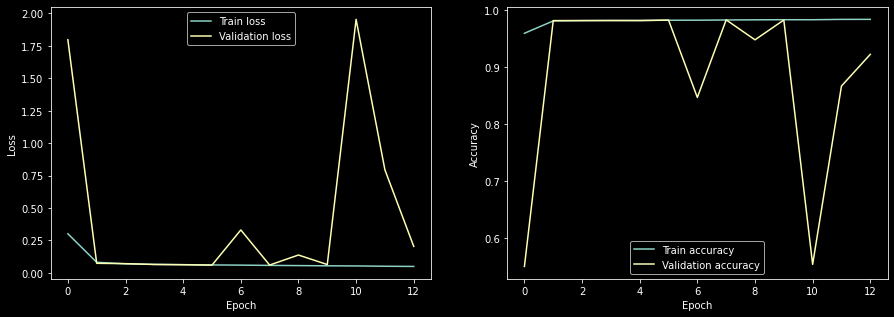

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, loss, label="Train loss")
ax_loss.plot(history.epoch, val_loss, label="Validation loss")
ax_loss.set_xlabel('Epoch')
ax_loss.set_ylabel('Loss')
ax_loss.legend()
ax_acc.plot(history.epoch, acc, label="Train accuracy")
ax_acc.plot(history.epoch, val_acc, label="Validation accuracy")
ax_acc.set_xlabel('Epoch')
ax_acc.set_ylabel('Accuracy')
ax_acc.legend()

# Making Predictions

Loading best model:

In [ ]:
model = load_model(file_model)

In [ ]:
preds_valid = model.predict(x_valid)
preds_valid.shape

2022-10-11 22:22:24.952754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 14s 190ms/step


(2275, 128, 128, 1)

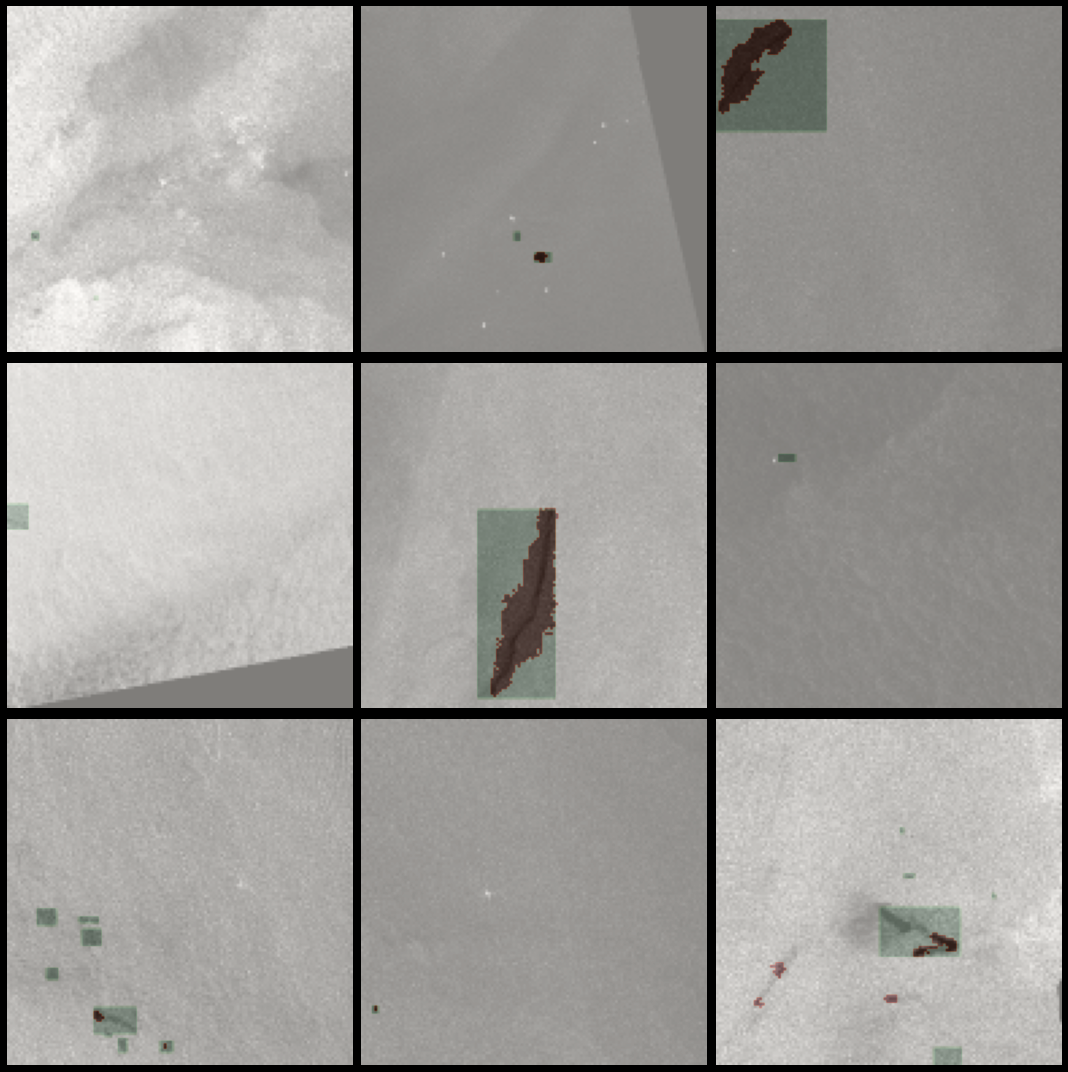

In [ ]:
def plotImageTranspValid(file1, file2, file3, k, alpha1 = 0.2, alpha2 = 0.2):
    fig, ax = plt.subplots(nrows=k, ncols=k, figsize=(15, 15))
    for i in range(k):
        for j in range(k):
            ind = randint(0,file1.shape[0]-1)
            ax[i,j].imshow(file1[ind], cmap='gray', vmin = 0, vmax = 1)
            ax[i,j].imshow(file2[ind], cmap='Greens', alpha = alpha1)
            ax[i,j].imshow(file3[ind], cmap='Reds', alpha = alpha2)
            ax[i,j].set_axis_off()

    fig.tight_layout()
    return(fig)

fig = plotImageTranspValid(x_valid[:,:,:,0], y_valid, np.round(preds_valid), k = 3, alpha1 = 0.3, alpha2 = 0.3)